# **LSTM & BiLSTM & GRU**

In [ ]:

!pip install konlpy -q


     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19.4/19.4 MB 28.8 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 488.6/488.6 kB 11.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import random  as rn
import tensorflow as tf

from konlpy.tag import Okt

from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, GRU

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import time
import datetime


import warnings
warnings.filterwarnings('ignore')


## **1) Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞**  

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

file_path = "/content/gdrive/My Drive/Colab Notebooks/wtm/finalproj/"


Mounted at /content/gdrive/


In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
hunjea_cases = pd.read_csv(file_path + "Î∂ÑÏïºÎ≥Ñ_ÌóåÏû¨ÌåêÎ°Ä.csv")

#Í∞úÏàòÍ∞Ä Ï†ÅÏùÄ 6Î≤à Ïπ¥ÌÖåÍ≥†Î¶¨Îäî ÏÇ≠Ï†ú
hunjea_cases = hunjea_cases[hunjea_cases.Category != 'ÌóåÎ≤ïÏúÑÏõêÌöå Î∞è ÎåÄÎ≤ïÏõê ÌóåÎ≤ïÌåêÎ°Ä']

#ÌóåÎ≤ïÏû¨ÌåêÏÜåÏóêÏÑú ÏßÄÏ†ïÌï¥Îëî CategoryÏóê ÎßûÍ≤å Num Î∂ÄÏó¨
ca_list = hunjea_cases['Category'].unique()
y = []

for i in range( len(hunjea_cases) ) :
  tmp = hunjea_cases['Category'][i]
  num = 0
  for j in ca_list :
    if j == tmp :
      y.append(num)
    else :
      num += 1

#dataFrameÏúºÎ°ú Î≥ÄÌôò
df_y = pd.DataFrame({"CaNum" : y})

#ÏµúÏ¢Ö df
findf = hunjea_cases.drop('Category', axis=1)
findf = findf.drop('CaseNum', axis=1)
alldf = pd.concat([df_y, findf], axis=1)

### Îç∞Ïù¥ÌÑ∞ split Î∞è Ï†ïÏ†ú

In [ ]:
train_data, test_data = train_test_split(alldf, test_size=0.2, random_state=1)

# Ï†ïÍ∑úÌëúÌòÑÏãù ÏÇ¨Ïö©ÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ Ï†ïÏ†ú
train_data['Content'] = [re.sub("[^„Ñ±-„Öé„Öè-„Ö£Í∞Ä-Ìû£ ]", " ", sent) for sent in train_data.Content]
#Í≥µÎ∞± Î∞è Îπà Í∞í Ï†úÍ±∞
train_data['Content'] = [re.sub("^ +", "", sent) for sent in train_data.Content]
train_data['Content'].replace("", np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')


# test Îç∞Ïù¥ÌÑ∞Ïóê ÏßÄÍ∏àÍπåÏßÄ ÏßÑÌñâÌñàÎçò Ï†ÑÏ≤òÎ¶¨ Í≥ºÏ†ïÎì§ÏùÑ ÎèôÏùºÌïòÍ≤å ÏßÑÌñâ

test_data['Content'] = [re.sub("[^„Ñ±-„Öé„Öè-„Ö£Í∞Ä-Ìû£ ]", " ", sent) for sent in test_data.Content]  # Ï†ïÍ∑ú ÌëúÌòÑÏãù ÏàòÌñâ
test_data['Content'] = [re.sub("^ +", "", sent) for sent in test_data.Content]    # Í≥µÎ∞±ÏùÄ empty Í∞íÏúºÎ°ú Î≥ÄÍ≤Ω
test_data['Content'].replace("", np.nan, inplace=True)                             # Í≥µÎ∞±ÏùÄ Null Í∞íÏúºÎ°ú Î≥ÄÍ≤Ω
test_data = test_data.dropna(how='any')                        # Null Í∞í Ï†úÍ±∞


### ÌÜ†ÌÅ∞Ìôî

In [ ]:
# Î∂àÏö©Ïñ¥Î•º Ï†ïÏùò

stopwords = ['Í∑úÏ†ï', 'Ï°∞Ìï≠', 'ÎåÄÌïú' ,'ÏÜåÏõê' ,'Î™©Ï†Å', 'ÏöîÏßÄ', 'ÌóåÎ≤ïÏÜåÏõêÏã¨Ìåê', 'ÌïÑÏöî', 'ÏÇ¨Í±¥', 'ÏúÑÌóå', 'Ìï©Ìóå', 'Î≤ïÎ•†', 'Ï†úÏ≤≠', 'Ï≤≠Íµ¨Ïù∏', 'Î≥ÄÌò∏Ïù∏', 'Ï†úÏ≤≠', 'Ïû¨Ìåê', 'ÌîºÍ≥†Ïù∏', 'Î≥ÄÌò∏ÏÇ¨', 'Ïã¨Ìåê', 'Ï≤≠Íµ¨' ,'Ïû¨ÌåêÍ¥Ä', 'Ïù¥Ïú†' ,'ÏúÑÌóåÌôïÏù∏', 'ÌîºÏ≤≠Íµ¨Ïù∏', 'ÏàòÏÇ¨' ,'Ïù¥Ïú†', 'ÏõêÏπô', 'Ïó¨Î∂Ä', 'ÌôïÏù∏', 'Ïö∞Î¶¨', 'Î≤ïÎ•†Ï°∞Ìï≠', 'Î∞òÎåÄÏùòÍ≤¨', 'ÌôïÏù∏', 'ÌïòÎÇò', 'Î¨¥Ïóá', 'Ï†úÌïú', 'Ïù∏Ï†ï', 'ÎåÄÏÉÅ', 'ÏûÖÎ≤ï', 'ÌóåÎ≤ïÏû¨ÌåêÏÜå', 'Ïû¨ÌåêÏÜå']
okt = Okt()

# train_dataÏóê ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞Î•º ÏÇ¨Ïö©ÌïòÏó¨ ÌÜ†ÌÅ∞ÌôîÎ•º ÌïòÎ©¥ÏÑú Î∂àÏö©Ïñ¥Î•º Ï†úÍ±∞ÌïòÏó¨ X_trainÏóê Ï†ÄÏû•
X_train = []

start = time.time()    # ÏãúÏûë ÏãúÍ∞Ñ Í∏∞Î°ù ==============================

for sentence in train_data['Content']:
    temp_X = okt.nouns(sentence)     # ÌÜ†ÌÅ∞Ìôî
    #CNNÏù¥ÎãàÍπå Topic ModelingÏù¥ÎûëÏùÄ Îã¨Î¶¨ nouns ÏïÑÎãàÍ≥† Í∑∏ÎÉ• ÌòïÌÉúÏÜå(morphs)Î°ú ÌïòÎäî Í±¥Í∞Ä,,,,,,,,,
    temp_X = [word for word in temp_X if  (len(word) > 1) and (not word in stopwords)] # Î∂àÏö©Ïñ¥ Ï†úÍ±∞
    X_train.append(temp_X)


processing_time = time.time() - start    # Í≤ΩÍ≥º ÏãúÍ∞Ñ Í≥ÑÏÇ∞  ==============================
times = str(datetime.timedelta(seconds = processing_time))
print()
print('‚ñ∂ ÏàòÌñâ ÏãúÍ∞Ñ = ', times)



‚ñ∂ ÏàòÌñâ ÏãúÍ∞Ñ =  0:02:24.511934


In [ ]:
# test Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ÏÑúÎèÑ ÎèôÏùºÌïòÍ≤å ÌÜ†ÌÅ∞ÌôîÎ•º ÏßÑÌñâ
X_test = []

start = time.time()    # ÏãúÏûë ÏãúÍ∞Ñ Í∏∞Î°ù ==============================

for sentence in test_data['Content']:
    temp_X = okt.nouns(sentence) # ÌÜ†ÌÅ∞Ìôî
    temp_X = [word for word in temp_X if  (len(word) > 1) and (not word in stopwords)] # Î∂àÏö©Ïñ¥ Ï†úÍ±∞
    X_test.append(temp_X)

processing_time = time.time() - start    # Í≤ΩÍ≥º ÏãúÍ∞Ñ Í≥ÑÏÇ∞  ==============================
times = str(datetime.timedelta(seconds = processing_time))
print()
print('‚ñ∂ ÏàòÌñâ ÏãúÍ∞Ñ = ', times)


‚ñ∂ ÏàòÌñâ ÏãúÍ∞Ñ =  0:00:37.699009


In [ ]:
# Ï†ïÏàò Ïù∏ÏΩîÎî©
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

sorted_items = sorted(tokenizer.word_index.items(), key=lambda item: item[1], reverse=True)

# ÏÉàÎ°úÏö¥ Îã®Ïñ¥ Ïù∏Îç±Ïä§ ÏÉùÏÑ± (ÎπàÎèÑÏàòÍ∞Ä ÎÜíÏùÄ Îã®Ïñ¥ÏùºÏàòÎ°ù ÌÅ∞ Ïà´ÏûêÎ•º Ìï†Îãπ)
reversed_word_index = {word: idx for idx, (word, _) in enumerate(sorted_items, 1)}

# ÏÉàÎ°úÏö¥ Îã®Ïñ¥ Ïù∏Îç±Ïä§Î•º tokenizerÏóê Ìï†Îãπ
tokenizer.word_index = reversed_word_index

tok_X_train = tokenizer.texts_to_sequences(X_train)
tok_X_test = tokenizer.texts_to_sequences(X_test)

y_train = np.array(train_data['CaNum'])
y_test = np.array(test_data['CaNum'])

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)


In [ ]:
# padding

max_len = 900

# Î™®Îì† ÏÉòÌîåÏùò Í∏∏Ïù¥Î•º nÏúºÎ°ú ÎßûÏ∂îÏñ¥ Ï§å

pad_X_train = pad_sequences(tok_X_train, maxlen = max_len)

pad_X_test = pad_sequences(tok_X_test, maxlen = max_len)

# n ÎØ∏ÎßåÏù∏ Ïï†Îì§ÏùÄ paddingÌï¥ÏÑú 0ÏúºÎ°ú Ï±ÑÏõå


## Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏

In [ ]:
print('‚óé train ÌåêÎ°Ä : {}'.format(len(pad_X_train)))
print('‚óé test ÌåêÎ°Ä : {}'.format(len(pad_X_test)))

‚óé train ÌåêÎ°Ä : 509
‚óé test ÌåêÎ°Ä : 126


In [ ]:
# Ï≤´Î≤àÏß∏ X_train ÌåêÎ°ÄÎ•º Ï∂úÎ†•
#
# ÌÜ†ÌÅ∞ÌôîÍ≥º Ï†ïÏàò Ïù∏ÏΩîÎî©(Í∞Å Îã®Ïñ¥Î•º Ï†ïÏàòÎ°ú Î≥ÄÌôò)Ïù¥ ÎÅùÎÇú ÏÉÅÌÉú

print('‚óé Ï≤´Î≤àÏß∏ train set ÌåêÎ°Ä :\n', pad_X_train[0])
print()

print('‚óé Ï≤´Î≤àÏß∏ train set ÌåêÎ°ÄÏùò Î†àÏù¥Î∏î : ', y_train[0])


‚óé Ï≤´Î≤àÏß∏ train set ÌåêÎ°Ä :
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   

In [ ]:
# Í∞Å Î†àÏù¥Î∏îÏóê ÎåÄÌïú Ï†ïÌôïÌïú Í∞úÏàòÎ•º ÌôïÏù∏

unique_elements, counts_elements = np.unique(y_train, return_counts=True)

print("‚óé Í∞Å Î†àÏù¥Î∏îÏóê ÎåÄÌïú ÎπàÎèÑÏàò:")

pd_data = pd.DataFrame(counts_elements, index=unique_elements, columns=["ÎπàÎèÑ"])

display(pd_data)


‚óé Í∞Å Î†àÏù¥Î∏îÏóê ÎåÄÌïú ÎπàÎèÑÏàò:


ÎπàÎèÑ
0.0  2036
1.0   509

In [ ]:
# Í∞Å Îã®Ïñ¥ÏôÄ Í∑∏ Îã®Ïñ¥Ïóê Î∂ÄÏó¨Îêú Ïù∏Îç±Ïä§Î•º Î¶¨ÌÑ¥
print(tokenizer.word_index)

{'ÍµêÌò∏Ïã†Î¨∏': 1, 'Ï£ºÎ≥ÄÏù∏': 2, 'ÎÇ†ÏÑ†': 3, 'ÏÑ±Ìíà': 4, 'Î≥µÍ∏∞': 5, 'Ï¶ùÍ±∞Î¨º': 6, 'ÏΩòÏÜî': 7, 'Ï†ÄÏû•Îß§Ï≤¥': 8, 'Ïù¥ÎèôÏãù': 9, 'Ïù∏Î©∏ÌïòÍ±∞': 10, 'ÎØ∏ÏßÑ': 11, 'Ïó∞Îã¨': 12, 'ÏÜçÎã®': 13, 'Î∂àÎ≤ïÏÑ†Í±∞': 14, 'ÎÑ§Ìä∏ÏõåÌÇπ': 15, 'Ï¥åÏßÄ': 16, 'Ï∞¨Ï°∞': 17, 'Ìé∏Îûå': 18, 'ÏöîÏãùÏóÖ': 19, 'ÏàòÏÇ∞Î¨º': 20, 'ÏûêÏπ´ÌïòÎ©¥': 21, 'Ï°∏ÏÜç': 22, 'ÏùºÏÜå': 23, 'Î∂ÄÏ°∞Î¶¨': 24, 'ÎúªÌï®': 25, 'Î∞∞ÏÜç': 26, 'ÏàòÌñâÌèâÍ∞Ä': 27, 'Í≤ΩÎß§': 28, 'ÏàòÏÉÅ': 29, 'Ìï≠Ïù¥ÎØÄ': 30, 'Î≥ÄÎ°†Í∏∞Ïùº': 31, 'Î™©ÎèÑ': 32, 'Ï∑®Ìï≠': 33, 'Î≥¥ÏïàÎ≤ï': 34, 'Ï¥âÏàò': 35, 'Ï∂úÍµ≠Ïã¨ÏÇ¨': 36, 'Ìá¥Ìèê': 37, 'Ïã¨ÏÑ±': 38, 'ÏóîÌÑ∞ÌîÑÎùºÏù¥Ï¶à': 39, 'ÏÑúÏ¥à': 40, 'ÏàòÍ±¥': 41, 'ÏßÅÏ†ëÍ∞ïÏ†ú': 42, 'Í¥ÄÏÉÅ': 43, 'ÌÉëÏû¨': 44, 'ÏäπÏö©ÏûêÎèôÏ∞®': 45, 'Ïù¥ÏÉÅÏùº': 46, 'ÏûÖÏàò': 47, 'ÏïàÍ∏∞Î∂Ä': 48, 'ÎÖπÏ∑®Î°ù': 49, 'ÌôçÏÑùÌòÑ': 50, 'Ïù¥ÌïôÏàò': 51, 'ÏïÑÎ¨¥': 52, 'Ï†ÑÏπò': 53, 'ÏàôÎ†§': 54, 'Î≤ïÏùòÌïô': 55, 'ÏùòÎåÄ': 56, 'Ïú†ÏïÑÏú§': 57, 'Î≥ëÏà†': 58, 'Ï†ïÍ∏∏': 59, 'ÎèÑÎ∞ï': 60, 'Í¥ÄÍ¥ëÍ∞ù': 61, 'Ïó∞Î•ú': 62, 'Îâ¥ÏãúÏä§'

In [ ]:
for key, value in tokenizer.word_counts.items():   # Îã®Ïñ¥ÏôÄ ÎπàÎèÑÏàòÏùò Ïåç(pair)ÏùÑ keyÏôÄ valueÎ°ú Î∞õÏùå
    print(f"{key} : {value}")

In [ ]:
# word_to_indexÏóêÏÑú keyÏôÄ valueÎ•º Î∞òÎåÄÎ°ú Ï†ÄÏû•Ìïú index_to_wordÎ•º ÎßåÎì¶
# => Ï†ïÏàòÎ°úÎ∂ÄÌÑ∞ Îã®Ïñ¥Î•º Ïïå Ïàò ÏûàÎèÑÎ°ù Ìï®


index_to_word = {}

for key, value in tokenizer.word_index.items():
    index_to_word[value] = key


In [ ]:
# Ïù∏Îç±Ïä§Î•º ÏûÖÎ†•ÌïòÏó¨ Îã®Ïñ¥Î•º ÌôïÏù∏ (1)

print('‚óé ÎπàÎèÑÏàò ÏÉÅÏúÑ 1Î≤à Îã®Ïñ¥ : {}'.format(index_to_word[1]))


‚óé ÎπàÎèÑÏàò ÏÉÅÏúÑ 1Î≤à Îã®Ïñ¥ : ÍµêÌò∏Ïã†Î¨∏


In [ ]:
# Ïù∏Îç±Ïä§Î•º ÏûÖÎ†•ÌïòÏó¨ Îã®Ïñ¥Î•º ÌôïÏù∏ (2)

print('‚óé ÎπàÎèÑÏàò ÏÉÅÏúÑ 130Î≤à Îã®Ïñ¥ : {}'.format(index_to_word[200]))


‚óé ÎπàÎèÑÏàò ÏÉÅÏúÑ 130Î≤à Îã®Ïñ¥ : Î∞©Ìå®


In [ ]:
# index_to_wordÏóêÏÑú Ïà´Ïûê 0ÏùÄ Ìå®Îî©ÏùÑ ÎπàÍ∞íÏúºÎ°ú ÏÑ§Ï†ï
#
# Ïù¥Î•º Î∞òÏòÅÌïòÏó¨ index_to_wordÎ•º ÏôÑÏÑ±

index_to_word[0] = ''


# X_train[0] ÎÇ¥Ïö© Î≥µÏõê

text = ' '.join([index_to_word[index] for index in pad_X_train[0]])

text


'                                                                                                                                                                                                                                                                                                                                                                                                                     Î∞∞Í≤Ω ÎØºÎ≤ï Î∂ÄÎèôÏÇ∞ Í∂åÎ¶¨ Îì±Í∏∞ ÎπÑÎ°úÏÜå ÎåÄÌïò Ìö®Î†• Î∞úÏÉù ÎåÄÎ≤ïÏõê Î∂ÄÌÑ∞ ÌåêÎ°Ä Î°úÏÑú Î∂ÄÎèôÏÇ∞ Ïã§Ïßà Í∂åÎ¶¨Ïûê ÏûêÏã† Îã§Î•∏ ÏÇ¨Îûå Ïù¥Î¶Ñ Îì±Í∏∞ ÏÜåÏúÑ Î™ÖÏùòÏã†ÌÉÅ Îì±Í∏∞ Í≤ΩÏö∞ Ïô∏Ï†Å Î™ÖÏùò ÌÉÅÏûê Í∂åÎ¶¨Ïûê ÎåÄÎÇ¥ Î™ÖÏùòÏã†ÌÉÅ Í∂åÎ¶¨ Î≥¥Ïú† Î™ÖÏùòÏã†ÌÉÅ Í≤ΩÏö∞ Ìà¨Í∏∞ ÌÉàÏÑ∏ ÌÉàÎ≤ï ÌñâÏúÑ ÏàòÎã® ÎÇ®Ïö© Íµ≠Ìöå Î∂ÄÎèôÏÇ∞ Ïã§Í∂å Î¶¨Ïûê Îì±Í∏∞ Ï†úÏ†ï Ïù¥Î•¥Î†ÄÎã§ Î∂ÄÎèôÏÇ∞ Î¨ºÍ∂å Î≥ÄÎèô Í≤ΩÏö∞ Î™ÖÏùòÏã†ÌÉÅ ÏïΩÏ†ï Î™ÖÏùò ÌÉÅÏûê Î™ÖÏùò Îì±Í∏∞ Ïã§Î™Ö Îì±Í∏∞ ÏùòÎ¨¥ Ï±ÑÎ¨¥ Î≥ÄÏ†ú Îã¥Î≥¥ Ï±ÑÍ∂åÏûê Î∂ÄÎèôÏÇ∞ Î¨ºÍ∂å Ïù¥Ï†Ñ Í≤ΩÏö∞ ÏñëÎèÑÎã¥Î≥¥ Ï±ÑÎ¨¥Ïûê Ï±ÑÍ∂å Í∏àÏï° Ï±ÑÎ¨¥ Î≥ÄÏ†ú 

## **2) LSTM**

In [ ]:
# Îì±Ïû• ÎπàÎèÑ ÏàúÏúÑ ÌïòÏúÑ 7000Í∞úÏùò Îã®Ïñ¥Îì§Îßå ÏÇ¨Ïö©

vocab_size = 8537 #ÎÇ¥Í∞Ä ÏÑ§Ï†ï (ÏÑ±Îä•Ïóê ÏòÅÌñ• ÎØ∏Ïπ®)

# Í∏∏Ïù¥Î•º 900ÏúºÎ°ú Ìå®Îî©
max_len = 900 #ÎÇ¥Í∞Ä ÏÑ§Ï†ï (ÏÑ±Îä•Ïóê ÏòÅÌñ• ÎØ∏Ïπ®)

In [ ]:
# ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò Ï∞®ÏõêÏùÄ 100
embedding_dim = 100

# ÏùÄÎãâ ÏÉÅÌÉúÏùò ÌÅ¨Í∏∞Îäî 128
hidden_units = 128

# 5Í∞úÏùò Î∂ÑÎ•ò Ï§ë ÌïòÎÇòÏùò ÏÑ†ÌÉùÏßÄÎ•º ÏòàÏ∏°ÌïòÎäî Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•ò Î¨∏Ï†ú
num_classes = 5

# Î™®Îç∏ ÏÑ§Ï†ï
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))    # ÌõàÎ†® ÌååÎùºÎØ∏ÌÑ∞ : embedding_dim * Ïñ¥ÌúòÏàò

model.add(LSTM(hidden_units, dropout=0.5))                      # ÌõàÎ†® ÌååÎùºÎØ∏ÌÑ∞ : 4(n*m+n*n+n)  /* n : hidden_units ÌÅ¨Í∏∞ , m : embedding_dim */

# Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•ò : ÏÜåÌîÑÌä∏Îß•Ïä§ Ìï®ÏàòÎ•º ÏÇ¨Ïö©
model.add(Dense(num_classes, activation='softmax'))  # ÌõàÎ†® ÌååÎùºÎØ∏ÌÑ∞ : (num_classes * hidden_units) + num_classes

model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 100)         853700    
                                                                 
 lstm_12 (LSTM)              (None, 128)               117248    
                                                                 
 dense_16 (Dense)            (None, 5)                 645       
                                                                 
Total params: 971593 (3.71 MB)
Trainable params: 971593 (3.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#@title üåê Call Back Ìï®Ïàò ÏÑ§Ï†ï

# (1) Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§(val_loss)Ïù¥ Ï¶ùÍ∞Ä~~ÌïòÎ©¥, Í≥ºÏ†ÅÌï© ÏßïÌõÑÏù¥ÎØÄÎ°ú Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§Ïù¥ 4Ìöå Ïù¥ÎÇ¥ Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ ÌïôÏäµÏùÑ Ï°∞Í∏∞ Ï¢ÖÎ£å(Early Stopping) ~~
#

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


# (2) ÎòêÌïú, ModelCheckpointÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïùò Ï†ïÌôïÎèÑ(val_acc)Í∞Ä Ïù¥Ï†ÑÎ≥¥Îã§ ~~~~~Ï¢ãÏïÑÏßà Í≤ΩÏö∞ÏóêÎßå (ÏµúÍ≥†Ïùº Í≤ΩÏö∞ÏóêÎßå)~~~ Î™®Îç∏ÏùÑ Ï†ÄÏû•

mc = ModelCheckpoint('best_model_LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
# Keras ÏÇ¨Ïö©Ïãú ÏµúÎåÄÌïú reproducible results Î•º ÏñªÍ∏∞ ÏúÑÌï¥ ÏïÑÎûò ÏΩîÎìú Ïã§Ìñâ (Îã®, ÏôÑÎ≤ΩÌïòÏßÄÎäî ÏïäÏùå)
#
# Îß§Î≤à Ï†ïÌôïÌïòÍ≤å ÎèôÏùºÌïú Í≤∞Í≥ºÎ•º ÏñªÍ∏∞ ÏúÑÌï¥ÏÑúÎäî (1) GPU ÎåÄÏã† CPU Î•º ÏÇ¨Ïö©ÌïòÍ≥†, (2) Mulithread Î•º ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÎèÑÎ°ù Ï°∞Ï†ï Ìï¥ÏïºÌï®
#

seed_num = 100

np.random.seed(seed_num)         # Numpy generated random numbers
rn.seed(seed_num)                # Python generated random numbers
tf.random.set_seed(seed_num)     # TensorFlow generated random numbers

# ÏÜêÏã§ Ìï®ÏàòÎ°ú ÌÅ¨Î°úÏä§ ÏóîÌä∏Î°úÌîº Ìï®ÏàòÎ•º ÏÇ¨Ïö©
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


%time history = model.fit(pad_X_train, y_train, batch_size=64, epochs=50, callbacks=[es, mc], validation_data=(pad_X_test, y_test))
#%time history = model.fit(pad_X_train, y_train, batch_size=64, epochs=50, validation_data=(pad_X_test, y_test)) #callback ÏóÜÎäî Î≤ÑÏ†Ñ


Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 1.6064 - acc: 0.2633
Epoch 1: val_acc improved from -inf to 0.21429, saving model to best_model_LSTM.h5
8/8 [==============================] - 23s 3s/step - loss: 1.6064 - acc: 0.2633 - val_loss: 1.6054 - val_acc: 0.2143
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.5819 - acc: 0.2633
Epoch 2: val_acc did not improve from 0.21429
8/8 [==============================] - 18s 2s/step - loss: 1.5819 - acc: 0.2633 - val_loss: 1.6102 - val_acc: 0.2143
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.6350 - acc: 0.3183
Epoch 3: val_acc improved from 0.21429 to 0.32540, saving model to best_model_LSTM.h5
8/8 [==============================] - 18s 2s/step - loss: 1.6350 - acc: 0.3183 - val_loss: 1.5864 - val_acc: 0.3254
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 1.5239 - acc: 0.4283
Epoch 4: val_acc did not improve from 0.32540
8/8 [==============================] - 1

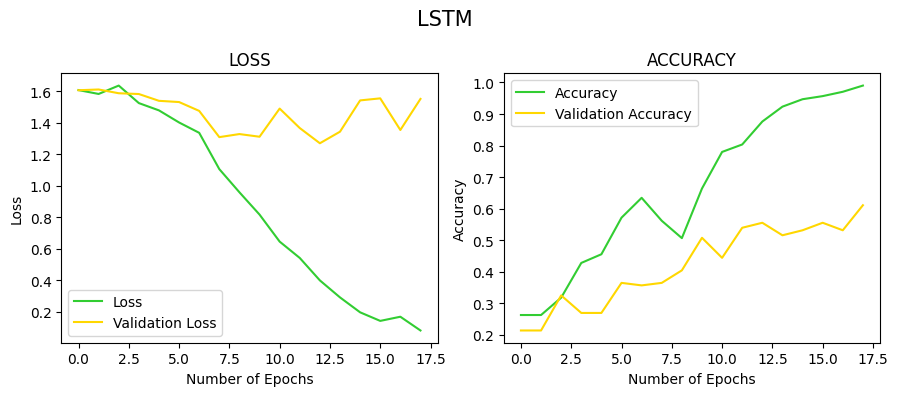

In [ ]:
fig = plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], color="limegreen", label = "Loss")
plt.plot(history.history['val_loss'], color="gold", label = "Validation Loss")
plt.title("LOSS")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], color="limegreen", label = "Accuracy")
plt.plot(history.history['val_acc'], color="gold", label = "Validation Accuracy")
plt.title("ACCURACY")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()

plt.suptitle("LSTM", fontsize=15)
fig.tight_layout() # ÏÇ¨Ïö©ÌïòÎ©¥ ÌîåÎ°ØÍ∞Ñ Ïó¨Î∞±ÏùÑ Ï°∞Ï†ï

plt.show()

In [ ]:
# Ï†ÄÏû•Îêú Î™®Îç∏Ïù∏ 'best_model.h5'Î•º Î°úÎìúÌïòÍ≥†, ÏÑ±Îä•ÏùÑ ÌèâÍ∞Ä

loaded_model = load_model('best_model_LSTM.h5')


# loaded_model.evaluate Ï∂úÎ†•Í∞í : loss & acc Í∞íÏù¥ Ï∂úÎ†•Îê®
#
# loss Í∞í Ï∂úÎ†•Ïãú [0]ÏúºÎ°ú Ìò∏Ï∂ú
# acc Í∞í Ï∂úÎ†•Ïãú [1]ÏúºÎ°ú Ìò∏Ï∂ú

# acc = loaded_model.evaluate(X_test, y_test)[1]

acc = loaded_model.evaluate(pad_X_test, y_test)

print(acc)
print()

print("\n‚óé ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: %.4f" % (acc[1]))


4/4 [==============================] - 3s 354ms/step - loss: 1.5504 - acc: 0.6111
[1.5504484176635742, 0.6111111044883728]


‚óé ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: 0.6111


### confusion matrix

4/4 [==============================] - 4s 873ms/step


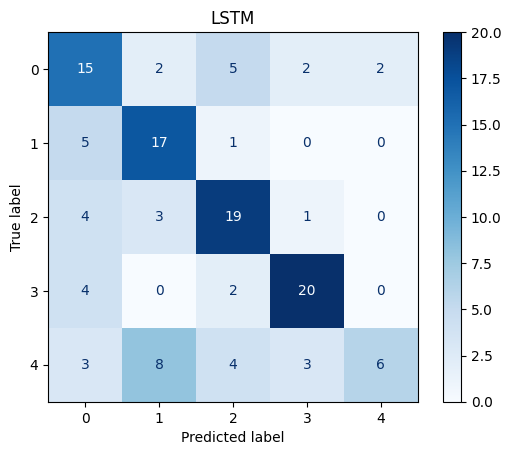

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = loaded_model.predict(pad_X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_re = np.argmax(y_test, axis=1)

# Confusion Matrix ÏÉùÏÑ±
cm = confusion_matrix(y_test_re, y_pred)

# Confusion Matrix ÏãúÍ∞ÅÌôî
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("LSTM")
plt.show()

## **3) BiLSTM**

In [ ]:
# Îì±Ïû• ÎπàÎèÑ ÏàúÏúÑ ÏÉÅÏúÑ nÍ∞úÏùò Îã®Ïñ¥Îì§Îßå ÏÇ¨Ïö©
vocab_size = 8537

# Î™®Îì† Í∏∏Ïù¥Î•º 900ÏúºÎ°ú Ìå®Îî©
max_len = 900

In [ ]:
# ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò Ï∞®ÏõêÏùÄ 100
embedding_dim = 100

# ÏùÄÎãâ ÏÉÅÌÉúÏùò ÌÅ¨Í∏∞Îäî 128
hidden_units = 128

# 5Í∞úÏùò Î∂ÑÎ•ò Ï§ë ÌïòÎÇòÏùò ÏÑ†ÌÉùÏßÄÎ•º ÏòàÏ∏°ÌïòÎäî Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•ò Î¨∏Ï†ú
num_classes = 5


# Î™®Îç∏ ÏÑ§Ï†ï
model_bi = Sequential()

model_bi.add(Embedding(vocab_size, embedding_dim))

model_bi.add(Bidirectional(LSTM(hidden_units, dropout=0.5)))        # >>>Bidirectional LSTM<<ÏùÑ ÏÇ¨Ïö©  üëàüëàüëà

model_bi.add(Dense(num_classes, activation='softmax')) # Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•ò Î¨∏Ï†úÏùò Í≤ΩÏö∞, ÏÜåÌîÑÌä∏Îß•Ïä§ Ìï®ÏàòÎ•º ÏÇ¨Ïö©


model_bi.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 100)         853700    
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 1089481 (4.16 MB)
Trainable params: 1089481 (4.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#@title üåê Call Back Ìï®Ïàò ÏÑ§Ï†ï
#
# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§(val_loss)Ïù¥ Ï¶ùÍ∞ÄÌïòÎ©¥, Í≥ºÏ†ÅÌï© ÏßïÌõÑÏù¥ÎØÄÎ°ú Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§Ïù¥ 4Ìöå Ïù¥ÎÇ¥ Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ ÌïôÏäµÏùÑ Ï°∞Í∏∞ Ï¢ÖÎ£å(Early Stopping)
#

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


# ÎòêÌïú, ModelCheckpointÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïùò Ï†ïÌôïÎèÑ(val_acc)Í∞Ä Ïù¥Ï†ÑÎ≥¥Îã§ Ï¢ãÏïÑÏßà Í≤ΩÏö∞ÏóêÎßå Î™®Îç∏ÏùÑ Ï†ÄÏû•

mc = ModelCheckpoint('best_model_biLSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [ ]:
# random seed ÏÑ§Ï†ï

seed_num = 100

np.random.seed(seed_num)         # Numpy generated random numbers
rn.seed(seed_num)                # Python generated random numbers
tf.random.set_seed(seed_num)     # TensorFlow generated random numbers

# ÏÜêÏã§ Ìï®ÏàòÎ°ú ÌÅ¨Î°úÏä§ ÏóîÌä∏Î°úÌîº Ìï®ÏàòÎ•º ÏÇ¨Ïö©
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

%time history = model_bi.fit(pad_X_train, y_train, batch_size=64, epochs=30, callbacks=[es, mc], validation_data=(pad_X_test, y_test))


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 1.6028 - acc: 0.2534
Epoch 1: val_acc improved from -inf to 0.21429, saving model to best_model_biLSTM.h5
8/8 [==============================] - 44s 5s/step - loss: 1.6028 - acc: 0.2534 - val_loss: 1.6162 - val_acc: 0.2143
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 1.5861 - acc: 0.2593
Epoch 2: val_acc did not improve from 0.21429
8/8 [==============================] - 35s 5s/step - loss: 1.5861 - acc: 0.2593 - val_loss: 1.6141 - val_acc: 0.2143
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 1.5311 - acc: 0.3045
Epoch 3: val_acc improved from 0.21429 to 0.33333, saving model to best_model_biLSTM.h5
8/8 [==============================] - 38s 5s/step - loss: 1.5311 - acc: 0.3045 - val_loss: 1.6611 - val_acc: 0.3333
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 1.4179 - acc: 0.4578
Epoch 4: val_acc did not improve from 0.33333
8/8 [==============================]

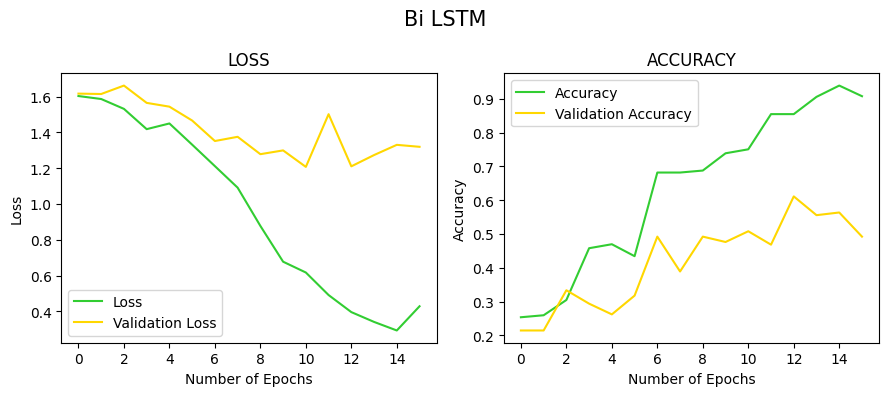

In [ ]:
fig = plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], color="limegreen", label = "Loss")
plt.plot(history.history['val_loss'], color="gold", label = "Validation Loss")
plt.title("LOSS")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], color="limegreen", label = "Accuracy")
plt.plot(history.history['val_acc'], color="gold", label = "Validation Accuracy")
plt.title("ACCURACY")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()

plt.suptitle("Bi LSTM", fontsize=15)
fig.tight_layout() # ÏÇ¨Ïö©ÌïòÎ©¥ ÌîåÎ°ØÍ∞Ñ Ïó¨Î∞±ÏùÑ Ï°∞Ï†ï

plt.show()

In [ ]:
# Ï†ÄÏû•Îêú Î™®Îç∏Ïù∏ 'best_model_biLSTM.h5'Î•º Î°úÎìúÌïòÍ≥†, ÏÑ±Îä•ÏùÑ ÌèâÍ∞Ä

loaded_model = load_model('best_model_biLSTM.h5')

acc = loaded_model.evaluate(pad_X_test, y_test)

print(acc)
print()

print("\n‚óé ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: %.4f" % (acc[1]))


4/4 [==============================] - 5s 641ms/step - loss: 1.2103 - acc: 0.6111
[1.2102848291397095, 0.6111111044883728]


‚óé ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: 0.6111


### confusion matrix

4/4 [==============================] - 6s 1s/step


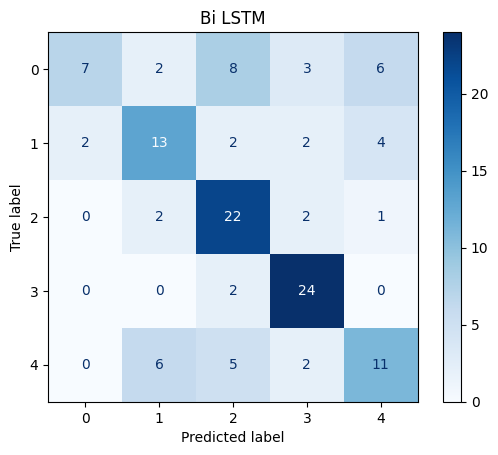

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = loaded_model.predict(pad_X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_re = np.argmax(y_test, axis=1)

# Confusion Matrix ÏÉùÏÑ±
cm = confusion_matrix(y_test_re, y_pred)

# Confusion Matrix ÏãúÍ∞ÅÌôî
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Bi LSTM")
plt.show()

## **4) GRU**

In [ ]:
# ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò Ï∞®ÏõêÏùÄ 100
embedding_dim = 100

# ÏùÄÎãâ ÏÉÅÌÉúÏùò ÌÅ¨Í∏∞Îäî 128
hidden_units = 128

# 5Í∞úÏùò Î∂ÑÎ•ò Ï§ë ÌïòÎÇòÏùò ÏÑ†ÌÉùÏßÄÎ•º ÏòàÏ∏°ÌïòÎäî Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•ò Î¨∏Ï†ú
num_classes = 5

# Î™®Îç∏ ÏÑ§Ï†ï

model_bi = Sequential()

model_bi.add(Embedding(vocab_size, embedding_dim))

model_bi.add(GRU(hidden_units, dropout=0.5))        # GRU ÏÇ¨Ïö©  üëàüëàüëà

model_bi.add(Dense(num_classes, activation='softmax')) # Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•ò Î¨∏Ï†úÏùò Í≤ΩÏö∞, ÏÜåÌîÑÌä∏Îß•Ïä§ Ìï®ÏàòÎ•º ÏÇ¨Ïö©


model_bi.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 100)         853700    
                                                                 
 gru_3 (GRU)                 (None, 128)               88320     
                                                                 
 dense_14 (Dense)            (None, 5)                 645       
                                                                 
Total params: 942665 (3.60 MB)
Trainable params: 942665 (3.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#@title üåê Call Back Ìï®Ïàò ÏÑ§Ï†ï
#
# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§(val_loss)Ïù¥ Ï¶ùÍ∞ÄÌïòÎ©¥, Í≥ºÏ†ÅÌï© ÏßïÌõÑÏù¥ÎØÄÎ°ú Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§Ïù¥ 4Ìöå Ïù¥ÎÇ¥ Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ ÌïôÏäµÏùÑ Ï°∞Í∏∞ Ï¢ÖÎ£å(Early Stopping)
#

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


# ÎòêÌïú, ModelCheckpointÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïùò Ï†ïÌôïÎèÑ(val_acc)Í∞Ä Ïù¥Ï†ÑÎ≥¥Îã§ Ï¢ãÏïÑÏßà Í≤ΩÏö∞ÏóêÎßå Î™®Îç∏ÏùÑ Ï†ÄÏû•

mc = ModelCheckpoint('best_model_GRU.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [ ]:
# random seed ÏÑ§Ï†ï

seed_num = 100

np.random.seed(seed_num)         # Numpy generated random numbers
rn.seed(seed_num)                # Python generated random numbers
tf.random.set_seed(seed_num)     # TensorFlow generated random numbers


# ÏÜêÏã§ Ìï®ÏàòÎ°ú ÌÅ¨Î°úÏä§ ÏóîÌä∏Î°úÌîº Ìï®ÏàòÎ•º ÏÇ¨Ïö©
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


# epochÎäî Ï¥ù 30Î≤àÏùÑ ÏàòÌñâ, (epoch Îãπ 1~2Ï¥à ÏÜåÏöî)
# batch_sizeÎäî 64Î°ú ÏÑ§Ï†ï
# ÎòêÌïú ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Ï§ë 20%Î•º Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Î°ú ÏÇ¨Ïö©ÌïòÎ©¥ÏÑú Ï†ïÌôïÎèÑÎ•º ÌôïÏù∏

%time history = model_bi.fit(pad_X_train, y_train, batch_size=64, epochs=30, callbacks=[es, mc], validation_data=(pad_X_test, y_test))


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 1.6057 - acc: 0.2083
Epoch 1: val_acc improved from -inf to 0.21429, saving model to best_model_GRU.h5
8/8 [==============================] - 22s 2s/step - loss: 1.6057 - acc: 0.2083 - val_loss: 1.6061 - val_acc: 0.2143
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 1.5861 - acc: 0.2593
Epoch 2: val_acc did not improve from 0.21429
8/8 [==============================] - 16s 2s/step - loss: 1.5861 - acc: 0.2593 - val_loss: 1.6102 - val_acc: 0.2143
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 1.5678 - acc: 0.2554
Epoch 3: val_acc did not improve from 0.21429
8/8 [==============================] - 16s 2s/step - loss: 1.5678 - acc: 0.2554 - val_loss: 1.6153 - val_acc: 0.2143
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 1.5300 - acc: 0.2574
Epoch 4: val_acc did not improve from 0.21429
8/8 [==============================] - 17s 2s/step - loss: 1.5300 - acc: 0.2574 -

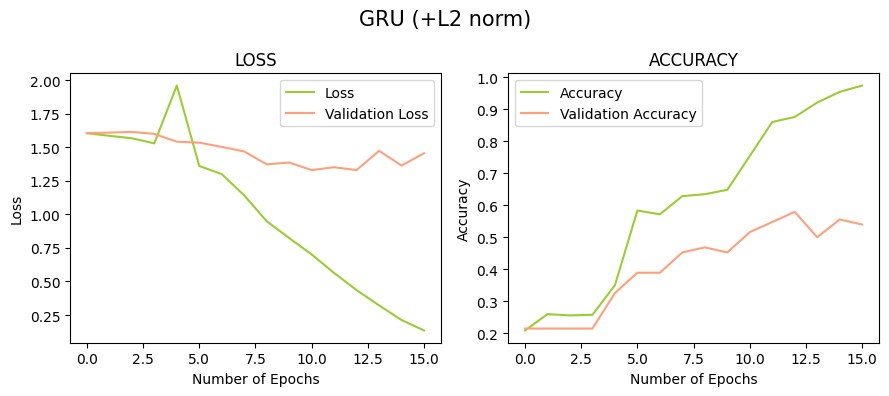

In [ ]:
fig = plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], color="yellowgreen", label = "Loss")
plt.plot(history.history['val_loss'], color="lightsalmon", label = "Validation Loss")
plt.title("LOSS")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], color="yellowgreen", label = "Accuracy")
plt.plot(history.history['val_acc'], color="lightsalmon", label = "Validation Accuracy")
plt.title("ACCURACY")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()

plt.suptitle("GRU (+L2 norm)", fontsize=15)
fig.tight_layout() # ÏÇ¨Ïö©ÌïòÎ©¥ ÌîåÎ°ØÍ∞Ñ Ïó¨Î∞±ÏùÑ Ï°∞Ï†ï

plt.show()

In [ ]:
# Ï†ÄÏû•Îêú Î™®Îç∏Ïù∏ 'best_model_GRU.h5'Î•º Î°úÎìúÌïòÍ≥†, ÏÑ±Îä•ÏùÑ ÌèâÍ∞Ä

loaded_model = load_model('best_model_GRU.h5')

# acc = loaded_model.evaluate(X_test, y_test)[1]

acc = loaded_model.evaluate(pad_X_test, y_test)

print(acc)
print()

print("\n‚óé ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: %.4f" % (acc[1]))
print(type(acc))


4/4 [==============================] - 3s 716ms/step - loss: 1.3308 - acc: 0.5794
[1.3307968378067017, 0.579365074634552]


‚óé ÌÖåÏä§Ìä∏ Ï†ïÌôïÎèÑ: 0.5794
<class 'list'>


### confusion matrix

4/4 [==============================] - 1s 209ms/step


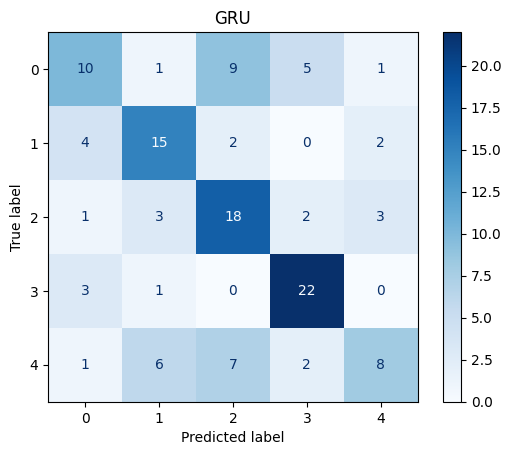

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = loaded_model.predict(pad_X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_re = np.argmax(y_test, axis=1)

# Confusion Matrix ÏÉùÏÑ±
cm = confusion_matrix(y_test_re, y_pred)

# Confusion Matrix ÏãúÍ∞ÅÌôî
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("GRU")
plt.show()

In [ ]:
loaded_model = load_model('best_model_GRU.h5')
acc3 = loaded_model.evaluate(pad_X_test, y_test)

loaded_model = load_model('best_model_LSTM.h5')
acc1 = loaded_model.evaluate(pad_X_test, y_test)

loaded_model = load_model('best_model_biLSTM.h5')
acc2 = loaded_model.evaluate(pad_X_test, y_test)


4/4 [==============================] - 6s 985ms/step - loss: 1.2103 - acc: 0.6111


In [ ]:
data = [acc4, acc1, acc2, acc3]

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
df = pd.DataFrame(data, columns=['loss', 'accuracy'], index=['CNN', 'LSTM', 'bi LSTM', 'GRU'])
df

loss  accuracy
LSTM     1.550448  0.611111
bi LSTM  1.210285  0.611111
GRU      1.330797  0.579365